In [1]:
import librosa
import matplotlib
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from scipy.signal import lfilter
from dataclasses import dataclass

from pymatreader import read_mat
import soundfile as sf

import phast
import abt

@dataclass
class MatlabData:
    M: np.ndarray
    T: np.ndarray
    I_det: np.ndarray
    greenwood_f: np.ndarray
    mat: object = None
    
    pw: float = 18e-6
    
    @staticmethod
    def read(path: str, m: int = 0, scaling_factor: float = 1.1) -> "MatlabData":
        mat = read_mat(path)
        TIa = mat["Df120"]["TIa"][m] * 1e-3
        TIb = mat["Df120"]["TIb"][m] * 1e-3
        I_det = TIa + TIb
        I_det = np.nan_to_num(I_det, nan=np.nanmax(I_det, axis=0))
        
        return MatlabData(
            M = mat['Df120']['M'][m] * scaling_factor,
            T = mat['Df120']['T'][m] * scaling_factor,
            I_det = MatlabData.transform_to_virtual(I_det),
            greenwood_f = np.flip(mat['Df120']['Fn'][m] * 1e3),
            mat=mat
        )
        
        
    @staticmethod
    def transform_to_virtual(i_det):
        reshaped = i_det[:, :i_det.shape[1] - 1, :].reshape(-1, i_det.shape[2]).T
        return np.flip(np.c_[reshaped, i_det[-1, -1, :]], axis=0)
    
    @property
    def i_det(self):
        'i_det no cs'
        return self.I_det[:, 4::8]
    
    def spatial_factor(self, fiber_idx, i_det):
        return np.nanmin(i_det, axis=0) / i_det[fiber_idx, :]

    def sigma(self, fiber_idx, i_det):
        return i_det[fiber_idx, :] * 0.06
   

def create_neurogram(fiber_stats, selected_fibers, binsize, duration):
    bins = np.arange(0, duration, binsize)
    data = np.zeros((len(selected_fibers), len(bins)))
    for i, fiber_idx in enumerate(selected_fibers):
        fs = [fs for fs in fiber_stats if fs.fiber_id == fiber_idx]
        spike_times = phast.spike_times(fs)
        idx = np.digitize(spike_times, bins)
        values, counts = np.unique_counts(idx)
        data[i, values] += counts
    return data

In [2]:
def TPloudness(TP,VL):
    # Bepaal luidheidsgroeicurve uit drempelprofiel
    # Let op: gaten in het drempelprofiel komen aan het eind van output-array I (en dus ook L) te staan!
    dL=0.5*abs(VL[1:]-VL[:-1])       # Helft van verschillen in afstand langs OC voor alle naburige vezels
    Wf=np.zeros(VL.shape)               # Array voor OC-breedte per vezel
    Wf[:-1] = Wf[:-1] + dL            # Helft van afstand naar volgende vezels
    Wf[1:]   = Wf[1:] + dL          # Plus de helft van de afstand naar de vorige vezels
    Wf[[0,-1]] = 2*Wf[[0, -1]]              # Eerste en laatste vezel worden gecorrigeerd voor het feit dat ze geen vorige respectievelijk volgende vezel hebben
    I, n = matlab_sort(TP)       # Drempelcurve wordt gesorteerd
    I = np.asarray(I)
    n = np.asarray(n)
    Wf_sort = Wf[n].ravel()                     # Excitatiebreedte per vezel wordt op dezelfde volgorde gesorteerd
    L=np.zeros(I.shape)                 # Array voor luidheid (in mm langs OC)
    L[0]= Wf_sort[0]                         # Excitatiebreedte laagstdrempelige vezel is Wf(1)
    for i in np.arange(1,len(I)):       # Elke volgende vezel voegt Wf(i) aan de excitatiebreedte toe
        L[i] = L[i-1]+Wf_sort[i]        #

    return I, L


def interpolindex(val, A):
    # Interpoleert een index n behorende bij een waarde val in een monotoon stijgend/dalend array A
    # Gebruikt lineaire interpolatie

    NA=len(A)
    if A[0] < A[-1]:
        k = 1
        dk = 1
    else:
        k=NA
        dk = -1
    while (A[k]<val) and (k+dk>=1) and (k+dk<=NA):
        k = k + dk
    if (A[k]>=val) and (k-dk>=1) and (k-dk<=NA):
        n1 = k-dk
        n2 = k 
        index=n1+1 + dk*(val-A[n1])/(A[n2]-A[n1]) # +1 for matlab indexing
    else:
        index=k

    return index

def interpolval(index,A):
    if not np.isnan(index):
        c = index-np.floor(index)
        n = int(np.floor(index))
        if n<len(A):
            if n>=1:
                val = (1-c)*A[n-1] + c*A[n]
            else:
                val = A[0]
        else:
            val = A[-1]
    else:
        val = np.nan

    return val

def DetermineThresholdLevel(TP,VL,Level):
    # TP    : drempelprofiel
    # VL    : posities van vezels langs basilair membraan (in mm)
    # Level : luidheidsniveau waarvoor stroomniveau bepaald moet worden (in mm)

    I,L =TPloudness(TP,VL)    # Bepaal luidheidsgroeicurve (I,L) uit drempelprofiel

    k=interpolindex(Level,L)  # Interpoleer de index van Level in L
    Itl=interpolval(k,I);     # Interpoleer de waarde van I op index k

    return Itl

def matlab_sort(array):
    if len(array.shape) > 1:
        array = np.squeeze(array)
    indices = [] 
    values = [] 
    remaining_array = array[~np.isnan(array)]
    while len(remaining_array) > 0 :
        min_val = np.nanmin(remaining_array)
        min_index = np.where(array == min_val)[0].tolist() # already sorts it ascendingly
        if len(min_index) > 1:
            indices.extend(min_index)
            values.extend(array[min_index])
        else:
            indices.append(min_index[0])
            values.append(array[min_index[0]])
        remaining_array = np.delete(remaining_array, np.where(remaining_array == min_val))

    return values, indices

def matlab_TM_thresholds(I_det, Ln, T_mm = 0.5, M_mm = 3.5):
    _, num_electrodes = I_det.shape
    T = np.zeros(num_electrodes)
    M = np.zeros(num_electrodes)
    

    for e in np.arange(num_electrodes):
        T[e] = DetermineThresholdLevel(np.expand_dims(I_det[:,e], axis=1), np.expand_dims(Ln, axis=1), T_mm) 
        M[e] = DetermineThresholdLevel(np.expand_dims(I_det[:,e], axis=1), np.expand_dims(Ln, axis=1), M_mm) 
    return T, M


8987.462
(80, 544)
(15, 111090)
<PulseTrain n_pulses: 55545 duration : 1.999620> 1.99962


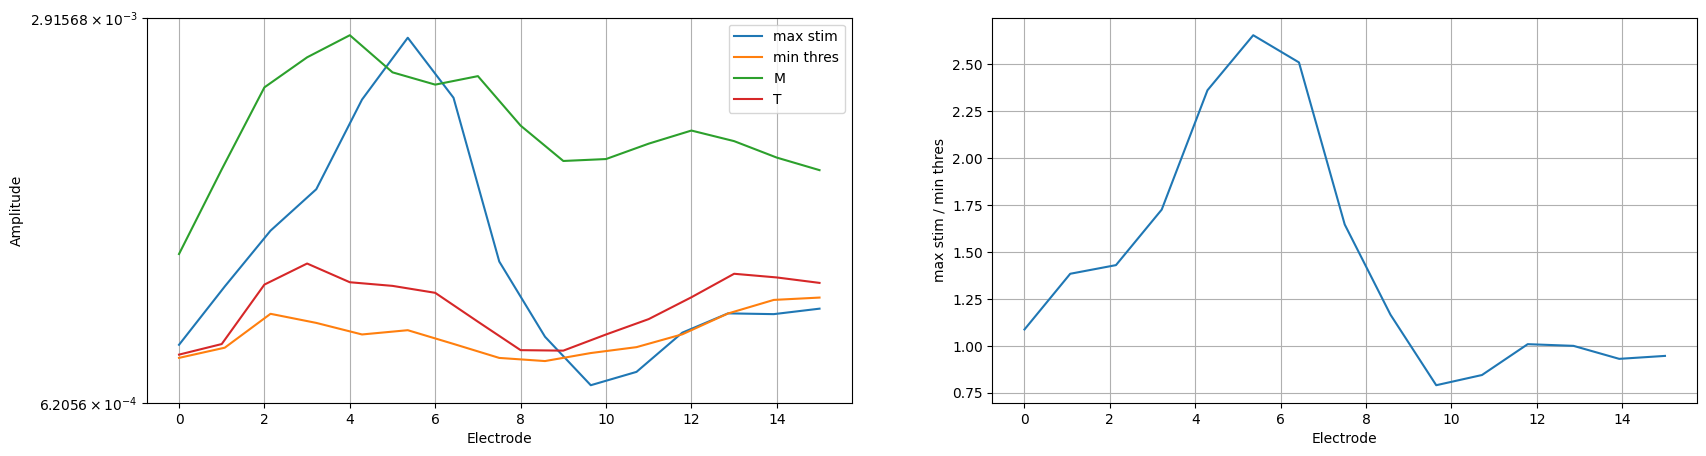

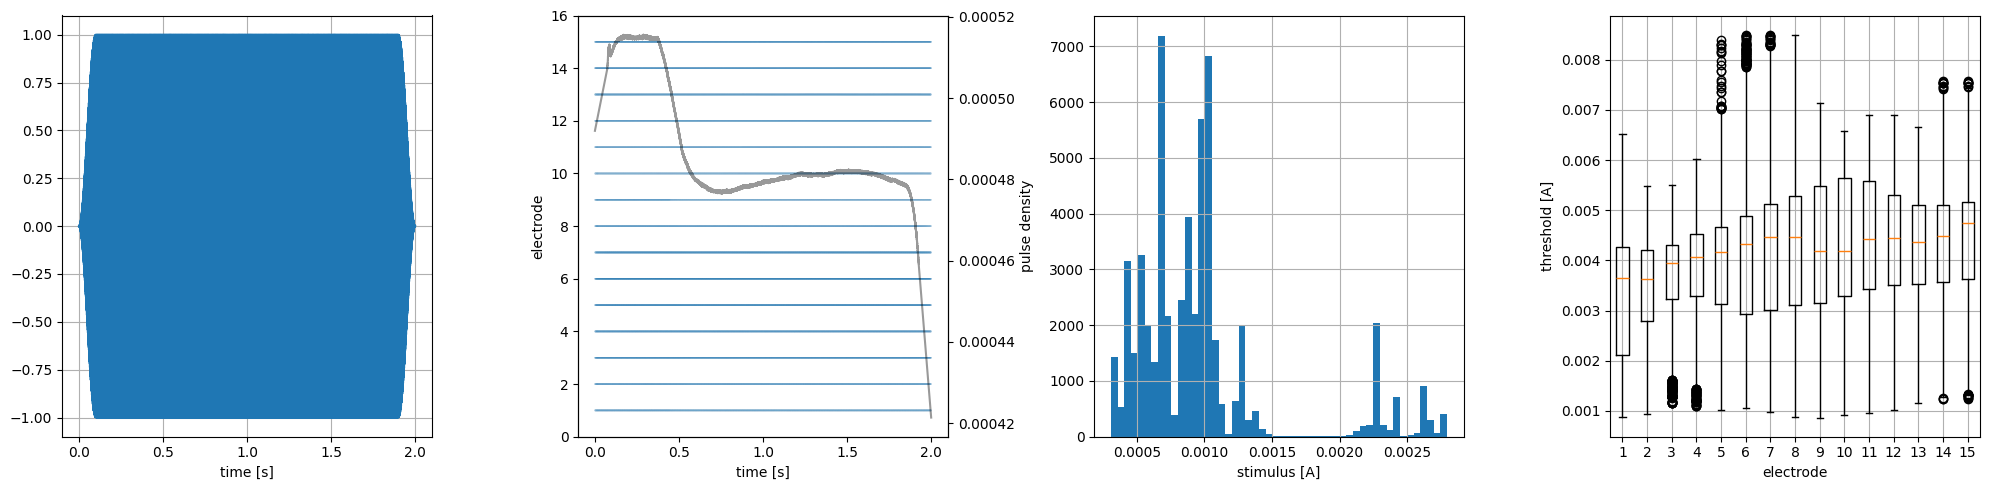

In [41]:
MIN_FREQ = 150
MAX_FREQ = 9000

FS = 17400
NAME = "tone_1kHz"
N_MELS = 80
N_FFT = 2048
N_HOP = N_FFT // 32
CS = False

MEL_SCALE = librosa.filters.mel_frequencies(N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ) 

MAT = MatlabData.read("Fidelity120 HC3A MS All Morphologies 18us CF.mat", scaling_factor=1)

T, M = matlab_TM_thresholds(
    np.load("idet_no_cs.npy"),
    np.flipud(MAT.mat["Df120"]["Ln"][0])   
)

IDET = MAT.I_det[:, 4::8] if not CS else MAT.I_det
scaling_factor = 3

pulse_train, audio_signal = abt.wav_to_electrodogram(
    abt.sounds[NAME], 
    current_steering=CS, 
    charge_balanced=False,  
    virtual_channels=True,
    apply_audiomixer=False,
    ramp_type = "cs",
    M=M * 1e6 / scaling_factor,
    T=T * 1e6 / scaling_factor,
    Fs = FS,
    stim_db = None,
    ramp_duration=0.1
)
pulse_train *= scaling_factor

audio_signal = audio_signal[0]

S = librosa.feature.melspectrogram(y=audio_signal, sr=FS, n_fft=N_FFT, hop_length=N_HOP, n_mels=N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ)
ref_db = np.max(S)

print(ref_db)
print(S.shape)

stimulus = phast.PulseTrain(pulse_train, time_step=MAT.pw)
duration = stimulus.t_max * MAT.pw
print(pulse_train.shape)
print(stimulus, duration)

f, (ax1,ax2)  = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(np.linspace(0, 15, pulse_train.shape[0]), pulse_train.max(axis=1), label="max stim")
ax1.plot(np.linspace(0, 15, IDET.shape[1]), IDET.min(axis=0), label="min thres")
ax1.plot(M, label="M")
ax1.plot(T, label="T")
ax1.legend()
ax1.grid()
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Electrode")
ax1.set_yscale("symlog")

ax2.plot(np.linspace(0, 15, pulse_train.shape[0]), pulse_train.max(axis=1) / IDET.min(axis=0))
ax2.set_ylabel("max stim / min thres")
ax2.set_xlabel("Electrode")
ax2.grid();

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(20, 5))

t_audio = np.arange(len(audio_signal)) * 1 / FS
ax1.plot(t_audio, audio_signal)
ax1.set_xlabel("time [s]")
ax1.grid()

e, t = np.where((pulse_train) > 0)
ax2.scatter(t * MAT.pw, e + 1, s=np.abs(pulse_train[e, t]))
ax2.set_ylim(1, pulse_train.shape[0])
ax2.set_xlabel("time [s]")
ax2.set_ylabel("electrode")
ax2.set_ylim(0, pulse_train.shape[0] + 1)

ax3.hist(np.abs(pulse_train[pulse_train > 0]), bins=50)
ax3.set_xlabel("stimulus [A]")
ax3.grid()

ax4.boxplot(IDET)
ax4.set_ylabel("threshold [A]")
ax4.set_xlabel("electrode")
ax4.grid()



density = scipy.signal.savgol_filter(pulse_train.sum(axis=0), 2048 * 4, 1).clip(0)
ax5 = ax2.twinx()
ax5.plot(np.arange(density.shape[0]) * MAT.pw, density, alpha=.4, color="black", zorder=-1)
ax5.set_ylabel("pulse density");

plt.tight_layout()


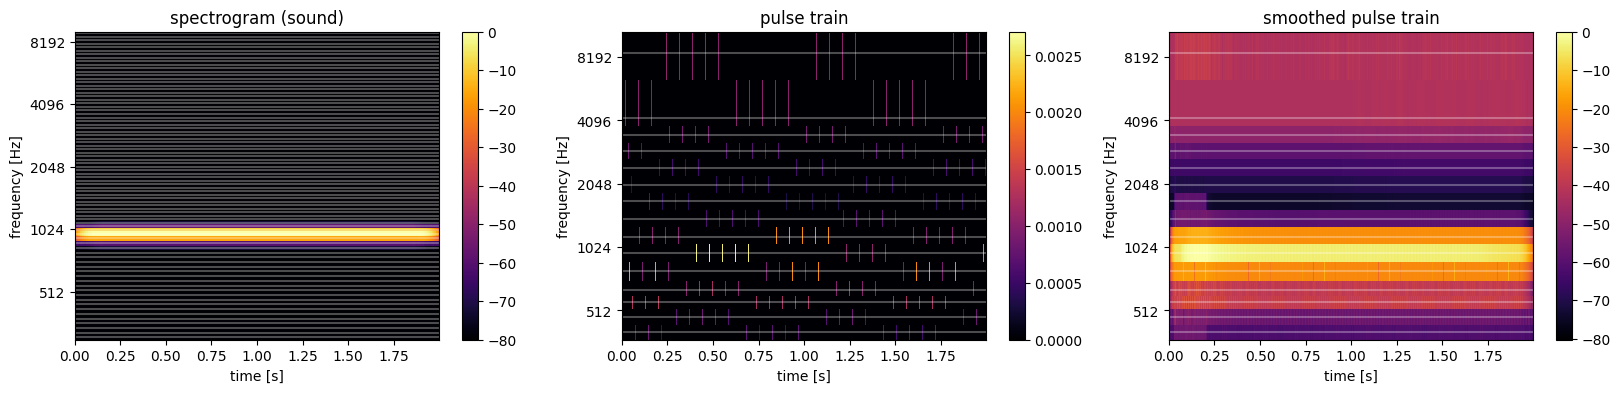

In [4]:
pdata = np.abs(pulse_train)
pdata = abt.utils.apply_filter(pdata, window_size=256, resample_to=pdata.shape[1], scale=True)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

S_db = librosa.power_to_db(S, ref=np.max)
ts = np.linspace(0, duration, len(S_db[0]))

abt.utils.plot_heatmap(ts, MEL_SCALE, S_db, ax1, f, pad_idx=False)
ax1.set_title("spectrogram (sound)")

abt.utils.plot_heatmap(
    np.arange(pulse_train.shape[1]) * MAT.pw,
    abt.utils.virtual_channel_frequencies(pulse_train.shape[0]),
    np.abs(pulse_train),
    ax=ax2,
    fig=f
)

ax2.set_title("pulse train")
abt.utils.plot_heatmap(
    np.arange(pulse_train.shape[1]) * MAT.pw,
    abt.utils.virtual_channel_frequencies(pulse_train.shape[0]),
    pdata,
    ax=ax3,
    fig=f
)
ax3.set_title("smoothed pulse train");

((15, 256), (15, 1025), (15, 1736))

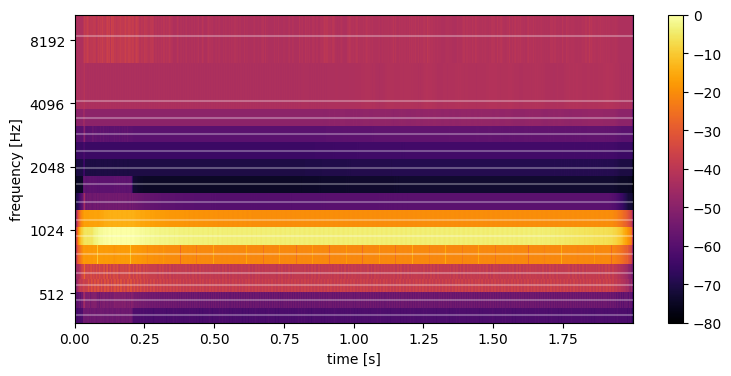

In [36]:
ref_db = np.max(S)
pdata = np.abs(pulse_train)
mel_spec_elec = abt.utils.apply_filter(pdata, window_size=256, scale=True)


t = np.linspace(0, duration, len(mel_spec_elec[0]))
freqs = abt.utils.virtual_channel_frequencies(pulse_train.shape[0])
abt.utils.plot_heatmap(t, freqs, mel_spec_elec)

basis, lenghts = librosa.filters.wavelet(freqs=freqs, sr=FS)
# F = np.abs(np.fft.fftn(basis, axes=[-1]))
# basis = F[:, :(1 + F.shape[1] // 2)]

# M = mel_spec_elec

basis2 = librosa.filters.mel(
    sr=FS, n_fft=N_FFT, n_mels=M.shape[-2], dtype=M.dtype, 
)

basis.shape, basis2.shape, mel_spec_elec.shape

# inverse = librosa.util.nnls(basis, mel_spec_elec)
# stft = np.power(inverse, 1.0 / 2.0, out=inverse)


# audio = librosa.core.spectrum.griffinlim(
#     stft,
#     n_fft=N_FFT,
#     dtype=M.dtype, 
# )
# plt.figure()
# plt.plot(np.linspace(0, duration, len(audio_signal)), audio_signal, label="original signal", alpha=.5)
# plt.plot(np.linspace(0, duration, len(audio)), audio, label="electrodogram resampled", alpha=.5)
# plt.legend()
# plt.grid()


In [7]:
stimulus = phast.PulseTrain(pulse_train, time_step=MAT.pw)

decay = phast.LeakyIntegratorDecay(
    accommodation_amplitude=0.072,
    adaptation_amplitude=7.142,
    accommodation_rate=0.014,
    adaptation_rate=19.996
)

selected_fibers = np.arange(3200)

fibers = []
for fiber_idx in selected_fibers:
    fibers.append(
        phast.Fiber(
            i_det=IDET[fiber_idx],
            spatial_constant=MAT.spatial_factor(fiber_idx, IDET) * .1,
            sigma=MAT.sigma(fiber_idx, IDET),  
            fiber_id=fiber_idx,
            n_max=stimulus.n_pulses,  
            decay=decay,  
            store_stats=False,
        )
    )
    

fiber_stats = phast.phast(fibers, stimulus, generate_trials = 1, evaluate_in_parallel=True)

duration = stimulus.time_step * stimulus.t_max
binsize = 1e-5

neurogram = create_neurogram(fiber_stats, selected_fibers, binsize, duration)
del fiber_stats
import gc;gc.collect()

KeyboardInterrupt: 

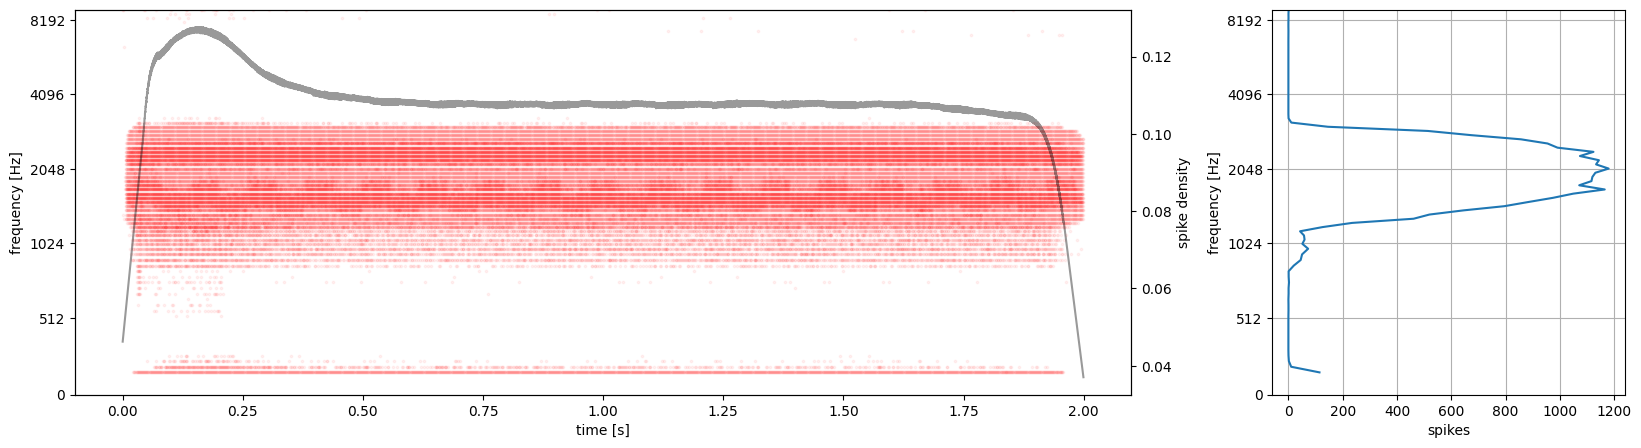

In [ ]:
neurogram_freq_bin = np.zeros((N_MELS, neurogram.shape[1]))
freq_bins = np.digitize(MAT.greenwood_f, MEL_SCALE)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), width_ratios=[3, 1])
for i in range(N_MELS):
    mask = freq_bins == i
    n_fibers = mask.sum()
    neurogram_freq_bin[i] = neurogram[mask].sum(axis=0) / n_fibers
    x = np.where(neurogram_freq_bin[i])[0]
    ax1.scatter(x * binsize, MEL_SCALE[i] * np.ones(len(x)), color="red", alpha=.05, s=3)
    
density = scipy.signal.savgol_filter(neurogram_freq_bin.sum(axis=0), 2048 * 4, 1).clip(0)
ax3 = ax1.twinx()
ax3.plot(np.arange(len(density)) * binsize, density, alpha=.4, color="black", zorder=-1)
ax3.set_ylabel("spike density")
      
ax2.plot(neurogram_freq_bin.sum(axis=1), MEL_SCALE)
ax2.grid()
ax2.set_xlabel("spikes")
abt.utils.frequency_ax(ax2)
abt.utils.time_vs_freq(ax1)
ax2.set_ylim(0, MAX_FREQ)
ax1.set_ylim(0, MAX_FREQ);     


(80, 544)

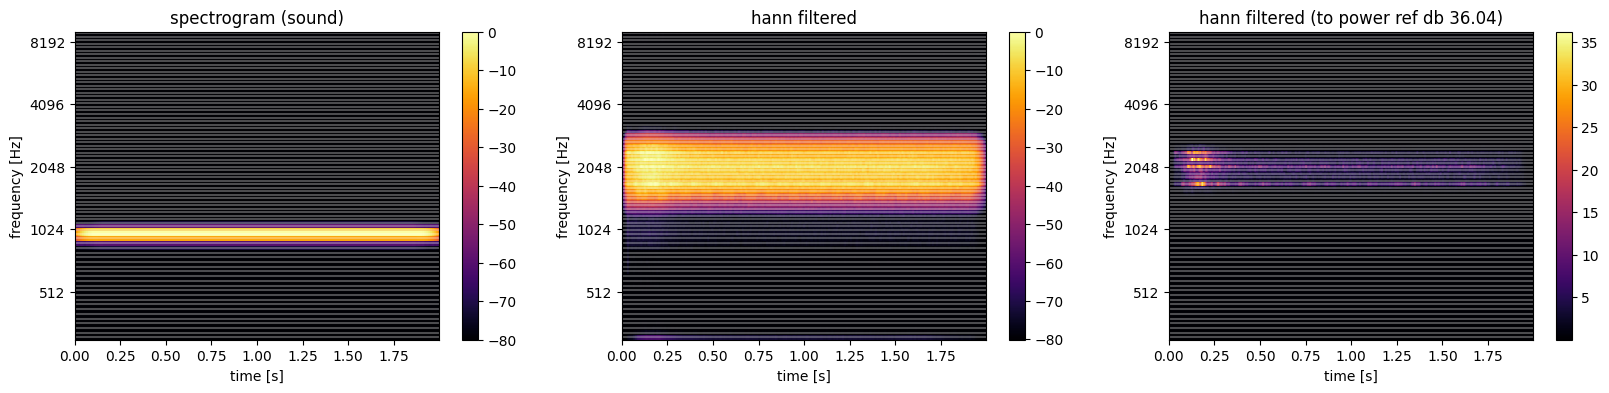

In [ ]:

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 4))

abt.utils.plot_heatmap(ts, MEL_SCALE, S_db, ax0, f)
ax0.set_title("spectrogram (sound)")

filtered_data = abt.utils.apply_filter(neurogram_freq_bin, resample_to=S.shape[1])

t = np.linspace(0, duration, len(filtered_data[0]))
abt.utils.plot_heatmap(t, MEL_SCALE, filtered_data, ax=ax1, fig=f)
ax1.set_title("hann filtered")

ref_db = np.max(S)
mel_spec_ng = librosa.db_to_power(filtered_data, ref=ref_db)
abt.utils.plot_heatmap(t, MEL_SCALE, mel_spec_ng, ax=ax2, fig=f)
ax2.set_title(f"hann filtered (to power ref db {ref_db:.2f})");
filtered_data.shape


In [ ]:
mel_inversed = librosa.feature.inverse.mel_to_audio(mel_spec_ng,  n_fft=N_FFT, hop_length=N_HOP, sr=FS, fmin=MIN_FREQ, fmax=MAX_FREQ)

mel_inversed = scipy.signal.resample(mel_inversed, audio_signal.size)

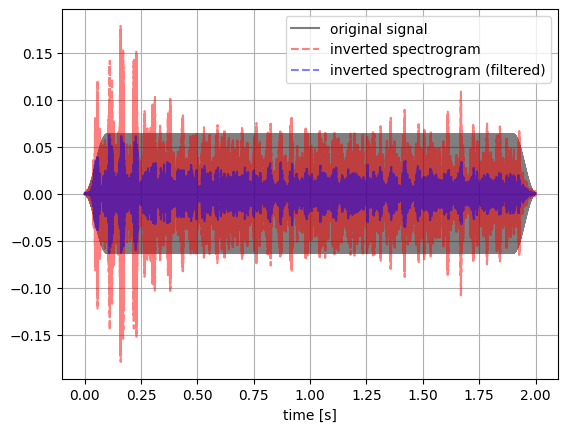

In [ ]:
sc = (audio_signal.max() - audio_signal.min()) / (mel_inversed.max() - mel_inversed.min())
# mel_inversed *= sc

t_audio = np.arange(len(audio_signal)) * 1 / FS
plt.plot(t_audio, audio_signal, label="original signal", color="black", alpha=.5)
plt.xlabel("time [s]")

t_mel = np.arange(len(mel_inversed)) * 1 / FS

plt.plot(
    t_mel, 
    mel_inversed,
    label="inverted spectrogram", 
    color ="red", 
    linestyle="dashed", 
    alpha=.5
)

mel_filt = scipy.signal.savgol_filter(mel_inversed, 64, 2) 
mel_filt *= (audio_signal.max() - audio_signal.min()) / (mel_filt.max() - mel_filt.min())

plt.plot(
    t_mel, mel_filt,
    label="inverted spectrogram (filtered)", color ="blue", linestyle="dashed", alpha=.5
) 
plt.grid()
plt.legend()

sf.write(
    f"output/{NAME}.wav", audio_signal, FS, subtype='PCM_24'
)

# sf.write(
#     f"output/mel_reconstructed_{NAME}_filt.wav", mel_filt, FS, subtype='PCM_24'
# )

sf.write(
    f"output/mel_reconstructed_{NAME}_ci.wav", mel_inversed, FS, subtype='PCM_24'
)


# n = int(np.ceil(mel_inversed.size * (16000 / FS)))
# mp3 = scipy.signal.resample(mel_inversed, n)
# sf.write(
#         f"output/mel_reconstructed_{NAME}_ci.mp3", mp3, 16000,
#         format='MP3', subtype='MPEG_LAYER_III'
# )




In [ ]:
mel_inversed.size, audio_signal.size



(34800, 34800)

In [ ]:
FS

17400